In [ ]:
#https://www.bgc-jena.mpg.de/wetter/weather_data.html

#download the   data under   WS Beutenberg   column   

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from keras.models import Model
from keras.layers import Dense,Input,Flatten
from keras.optimizers import RMSprop

In [ ]:
base_path = '/content/drive/MyDrive/jupyter_notebooks/deep_learning_fc/data/time_series_data/'
files = glob.glob(os.path.join(base_path,'*.csv'))
files

['/content/drive/MyDrive/jupyter_notebooks/deep_learning_fc/data/time_series_data/mpi_roof_2009a.csv',
 '/content/drive/MyDrive/jupyter_notebooks/deep_learning_fc/data/time_series_data/mpi_roof_2009b.csv',
 '/content/drive/MyDrive/jupyter_notebooks/deep_learning_fc/data/time_series_data/mpi_roof_2010a.csv',
 '/content/drive/MyDrive/jupyter_notebooks/deep_learning_fc/data/time_series_data/mpi_roof_2010b.csv',
 '/content/drive/MyDrive/jupyter_notebooks/deep_learning_fc/data/time_series_data/mpi_roof_2011a.csv',
 '/content/drive/MyDrive/jupyter_notebooks/deep_learning_fc/data/time_series_data/mpi_roof_2011b.csv',
 '/content/drive/MyDrive/jupyter_notebooks/deep_learning_fc/data/time_series_data/mpi_roof_2012a.csv',
 '/content/drive/MyDrive/jupyter_notebooks/deep_learning_fc/data/time_series_data/mpi_roof_2012b.csv',
 '/content/drive/MyDrive/jupyter_notebooks/deep_learning_fc/data/time_series_data/mpi_roof_2013a.csv',
 '/content/drive/MyDrive/jupyter_notebooks/deep_learning_fc/data/time_ser

In [ ]:
dfs = []
for file in files:
  df = pd.read_csv(file,encoding='latin1')
  dfs.append(df)
data = pd.concat(dfs,axis=0,ignore_index=True)
data.shape

(420551, 22)

In [ ]:
data.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m²)',
       'PAR (µmol/m²/s)', 'max. PAR (µmol/m²/s)', 'Tlog (degC)', 'CO2 (ppm)'],
      dtype='object')

In [ ]:
data_n = data[['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)']]

In [ ]:
data_n.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1


**converting data to numpy array**

In [ ]:
#selecting numeric columns only
cols = data_n.select_dtypes(np.number).columns
data_n = data_n[cols]
data_n.head(2)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1


In [ ]:
float_data = data_n.to_numpy(dtype='float32')
float_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]], dtype=float32)

In [ ]:
temp = float_data[:,1]
temp

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82], dtype=float32)

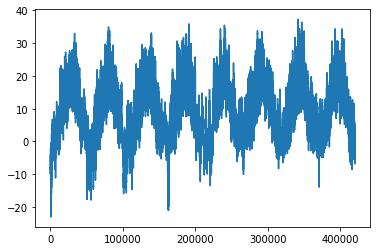

In [ ]:
plt.plot(range(1,len(temp)+1),temp)

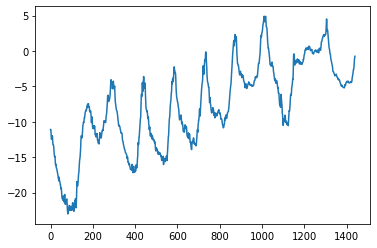

In [ ]:
#since, data is recorded every 10 mins
#so, per day we get  total_min_per_day/10   =  24*60/10  = 144
#in 10 days we get 1440 samples

plt.plot(range(1440),temp[800:2240])

# **Preparing Data**

**data normalization**

In [ ]:
#we plan on using first 200000 timesteps as training data
#so we compute the mean nd std dev only on this fraction data:

mean = float_data[:200000].mean(axis=0)
std = float_data[:200000].std(axis=0)

float_data-=mean    #but we  normalize the entire data using mean nd std calculated on training data
float_data/=std

**python generator that takes our current array of float data and yields batches of data from the recent past alongside with a target temp in future**

In [ ]:
#lookback = 720 i.e. our input data will go back 5 days
#delay= 288 i.e. our targets will be 2 days in future
#steps=6  data sampling rate i.e. 6*10=60 mins = 1hr i.e. sampling one data point per hour

In [ ]:
def  generator(data,  lookback,  delay,  min_index,  max_index,  shuffle=False,  batch_size=128,  step=6):
  if max_index is None:
    max_index = len(data) - delay -1
  
  i = min_index + lookback

  while 1:
    
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, batch_size)

    else:
      if i+batch_size>= max_index:
        i = min_index + lookback

      rows = np.arange(i,min(i+batch_size,max_index))
      i+= len(rows)
                               #samples in batch  #data pts in single sample   #columns in a data pt
    samples_in_batch = np.zeros((   len(rows),      lookback//step,             data.shape[-1]  )) 
    targets = np.zeros((len(rows),))

    for j , row in enumerate(rows):
      indices = np.arange(rows[j]-lookback,rows[j], step)
      samples_in_batch[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]   #here target is temp only

    yield samples_in_batch, targets

In [ ]:
lookback = 1440
delay = 144
step = 6 
batch_size = 128

train_gen = generator(float_data, lookback, delay, min_index=0, max_index=200000, shuffle=True)
val_gen =  generator(float_data, lookback, delay, min_index=200001, max_index=300000)
test_gen = generator(float_data, lookback, delay, min_index=300001, max_index=None)

#this is how many steps to draw from 'val_gen' in order to see the whole validation set:
val_steps = (300000-200001)//batch_size
#this is how many steps to draw from 'test_gen' in order to see the whole test set:
test_steps = (len(float_data)-300001)//batch_size

# **Fully Connected Model**

In [ ]:
input = Input(shape=(lookback//step,float_data.shape[-1]))

flat = Flatten()(input)
output = Dense(32,activation='relu')(flat)
output = Dense(1)(output)

model = Model(inputs=input,outputs=output)
model.compile(optimizer=RMSprop(learning_rate=1e-4),loss='mse',metrics=['mae'])
model.fit_generator(train_gen,steps_per_epoch=500,epochs=20, validation_data=val_gen,validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 16s 31ms/step - loss: 0.5070 - mae: 0.5512 - val_loss: 0.2565 - val_mae: 0.3989
Epoch 2/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2541 - mae: 0.3966 - val_loss: 0.4432 - val_mae: 0.5409
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2078 - mae: 0.3590 - val_loss: 0.2493 - val_mae: 0.3986
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.1810 - mae: 0.3351 - val_loss: 0.2339 - val_mae: 0.3864
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.1684 - mae: 0.3222 - val_loss: 0.4192 - val_mae: 0.5310
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.1490 - mae: 0.3036 - val_loss: 0.1981 - val_mae: 0.3520
Epoch 7/20
500/500 [==============================] - 15s 31ms/step - loss: 0.1405 - mae: 0.2935 - val_loss: 0.2002 - val_mae: 0.3565
Epoch 8/20
500/500 [==============================] - 16s 32ms

**Loss curves for validation and training**

In [ ]:
dict_ = model.history.history
dict_.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [ ]:
train_loss = dict_['loss']
val_loss = dict_['val_loss']
epochs = range(1,len(train_loss)+1)

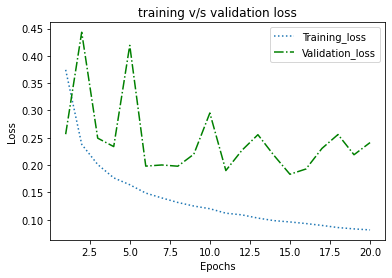

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epochs,train_loss,ls=':',label='Training_loss')
plt.plot(epochs,val_loss,ls='-.',color='green',label='Validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('training v/s validation loss')
plt.legend()

# **Recurrent baseline Model**

In [ ]:
from keras.layers import GRU

In [ ]:
input = Input(shape=(lookback//step,float_data.shape[-1]))

output = GRU(32)(input)
output = Dense(1)(output)

model = Model(inputs = input, outputs=output)
model.compile(optimizer=RMSprop(),loss='mae')
model.fit_generator(train_gen,steps_per_epoch=500, epochs=20, validation_data=val_gen,validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 96s 188ms/step - loss: 0.3504 - val_loss: 0.2730
Epoch 2/20
500/500 [==============================] - 94s 189ms/step - loss: 0.2866 - val_loss: 0.2754
Epoch 3/20
500/500 [==============================] - 94s 189ms/step - loss: 0.2796 - val_loss: 0.2677
Epoch 4/20
500/500 [==============================] - 95s 191ms/step - loss: 0.2738 - val_loss: 0.2649
Epoch 5/20
500/500 [==============================] - 96s 192ms/step - loss: 0.2677 - val_loss: 0.2717
Epoch 6/20
500/500 [==============================] - 96s 193ms/step - loss: 0.2627 - val_loss: 0.2602
Epoch 7/20
500/500 [==============================] - 94s 189ms/step - loss: 0.2568 - val_loss: 0.2634
Epoch 8/20
500/500 [==============================] - 96s 192ms/step - loss: 0.2540 - val_loss: 0.2632
Epoch 9/20
500/500 [==============================] - 95s 190ms/step - loss: 0.2498 - val_loss: 0.2666
Epoch 10/20
500/500 [==============================] - 95s 190ms/step - l

**Loss curves for training and validation**

In [ ]:
dict_ = model.history.history
dict_.keys()

train_loss = dict_['loss']
val_loss = dict_['val_loss']
epochs = range(1,len(train_loss)+1)

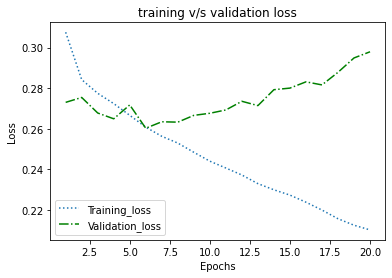

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epochs,train_loss,ls=':',label='Training_loss')
plt.plot(epochs,val_loss,ls='-.',color='green',label='Validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('training v/s validation loss')
plt.legend()

# **Using Recurrent Dropout  AND  Slower Learning Rate to fight overfitting**

In [ ]:
#it is evident from our training and validation curves that our model is overfitting:
#The training and validation losses starts diverging considerably after a few epochs.

#Every recurrent layer in keras has two dropout-related aruments:
#dropout: a float specifying the dropout rate for input units of the layer
#recurrent_dropout: specifying dropout rate of the recurrent units

#Because network being regularized with dropout always take longer to fully converge, we will train our network for twice as many epochs.

input = Input(shape=(lookback//step,float_data.shape[-1]))

output = GRU(32,dropout=0.2, recurrent_dropout=0.5)(input)
output = Dense(1)(output)

model = Model(inputs = input, outputs=output)
model.compile(optimizer=RMSprop(learning_rate=1e-4),loss='mae')
model.fit_generator(train_gen,steps_per_epoch=500, epochs=40, validation_data=val_gen,validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 155s 305ms/step - loss: 0.7410 - val_loss: 0.2990
Epoch 2/40
500/500 [==============================] - 153s 306ms/step - loss: 0.3492 - val_loss: 0.2871
Epoch 3/40
500/500 [==============================] - 153s 307ms/step - loss: 0.3284 - val_loss: 0.2854
Epoch 4/40
500/500 [==============================] - 154s 308ms/step - loss: 0.3225 - val_loss: 0.2851
Epoch 5/40
500/500 [==============================] - 155s 310ms/step - loss: 0.3194 - val_loss: 0.2831
Epoch 6/40
500/500 [==============================] - 154s 308ms/step - loss: 0.3158 - val_loss: 0.2828
Epoch 7/40
500/500 [==============================] - 153s 305ms/step - loss: 0.3153 - val_loss: 0.2791
Epoch 8/40
500/500 [==============================] - 154s 308ms/step - loss: 0.3141 - val_loss: 0.2835
Epoch 9/40
500/500 [==============================] - 154s 309ms/step - loss: 0.3118 - val_loss: 0.2806
Epoch 10/40
500/500 [==============================] - 153s 307m

In [ ]:
dict_ = model.history.history
dict_.keys()

train_loss = dict_['loss']
val_loss = dict_['val_loss']
epochs = range(1,len(train_loss)+1)

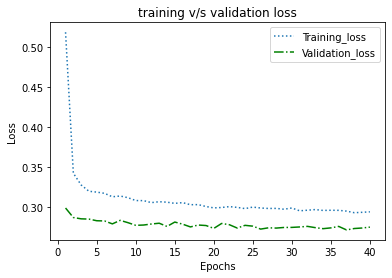

In [ ]:
plt.plot(epochs,train_loss,ls=':',label='Training_loss')
plt.plot(epochs,val_loss,ls='-.',color='green',label='Validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('training v/s validation loss')
plt.legend()

In [ ]:
#Great success: we are no longer ovverfitting. However, our best scores has not improved significantly from the previous one.

# **Stacking Recurrent Layers**

In [ ]:
#since we are no longer overfitting yet we seem to have hit a performance bottlenack
#we should start considering increasing the capacity of our network

input = Input(shape=(lookback//step,float_data.shape[-1]))

output = GRU(32,dropout=0.2, recurrent_dropout=0.5,return_sequences=True)(input)
output = GRU(64,dropout=0.2, recurrent_dropout=0.5,activation='relu')(output)
output = Dense(1)(output)

model = Model(inputs = input, outputs=output)
model.compile(optimizer=RMSprop(learning_rate=1e-4),loss='mae')
model.fit_generator(train_gen,steps_per_epoch=500, epochs=40, validation_data=val_gen,validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 409s 808ms/step - loss: 0.5182 - val_loss: 0.3027
Epoch 2/40
500/500 [==============================] - 407s 815ms/step - loss: 0.3309 - val_loss: 0.2934
Epoch 3/40
500/500 [==============================] - 408s 817ms/step - loss: 0.3254 - val_loss: 0.2898
Epoch 4/40
500/500 [==============================] - 407s 814ms/step - loss: 0.3202 - val_loss: 0.2859
Epoch 5/40
500/500 [==============================] - 406s 813ms/step - loss: 0.3186 - val_loss: 0.2852
Epoch 6/40
500/500 [==============================] - 405s 811ms/step - loss: 0.3160 - val_loss: 0.2855
Epoch 7/40
500/500 [==============================] - 406s 812ms/step - loss: 0.3149 - val_loss: 0.2811
Epoch 8/40
500/500 [==============================] - 406s 812ms/step - loss: 0.3130 - val_loss: 0.2861
Epoch 9/40
500/500 [==============================] - 404s 808ms/step - loss: 0.3116 - val_loss: 0.2802
Epoch 10/40
500/500 [==============================] - 399s 799m

**Training v/s Validation Results**

In [ ]:
dict_ = model.history.history
dict_.keys()

train_loss = dict_['loss']
val_loss = dict_['val_loss']
epochs = range(1,len(train_loss)+1)

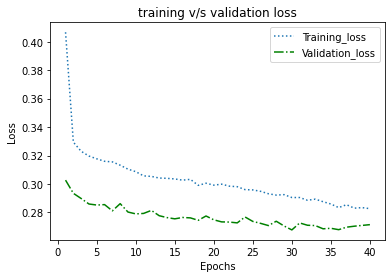

In [ ]:
plt.plot(epochs,train_loss,ls=':',label='Training_loss')
plt.plot(epochs,val_loss,ls='-.',color='green',label='Validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('training v/s validation loss')
plt.legend()

**adding layers does improve ours results by a bit, albeit not very significantly.**

# **Processing input sequences in antichronological order with  RNN's**

In [ ]:
#RNN layers in this section have so far processed sequences in chronological order (older timesteps first)
#Could it be that our RNNs could have performed well enough if it were processing input sequences in antichronological order(newer timesteps first)?
#Let's try this in practice and see what we get.

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):

  if max_index is None:
    max_index = len(data) - delay - 1

  i = min_index + lookback

  while 1:
    
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, batch_size)

    else:
      if i+batch_size>=max_index:
        i = min_index + lookback
      
      rows = np.arange(i,min(i+batch_size,max_index))
      i+= len(rows)



    samples_in_batch = np.zeros((len(rows),  lookback//step,  data.shape[-1]))
    targets = np.zeros((len(rows),))


    for j, row in enumerate(rows):
      indices = np.arange(rows[j]-lookback,rows[j], step)
      samples_in_batch[j] = data[indices]
      targets[j] = data[rows[j]+delay][1]

    yield samples_in_batch[:,::-1,:], targets


In [ ]:
train_gen_rev = reverse_order_generator(float_data, lookback, delay, min_index=0, max_index=200000,shuffle=True)
val_gen_rev = reverse_order_generator(float_data, lookback, delay, min_index=200001, max_index=300000)
test_gen_rev = reverse_order_generator(float_data, lookback, delay, min_index=300001, max_index=None)

In [ ]:
input = Input(shape=(lookback//step,float_data.shape[-1]))

output = GRU(32)(input)
output = Dense(1)(output)

model = Model(inputs = input, outputs=output)
model.compile(optimizer=RMSprop(),loss='mae')
model.fit_generator(train_gen_rev,steps_per_epoch=500, epochs=20, validation_data=val_gen_rev, validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 85s 166ms/step - loss: 0.4923 - val_loss: 0.4843
Epoch 2/20
500/500 [==============================] - 83s 166ms/step - loss: 0.4576 - val_loss: 0.4865
Epoch 3/20
500/500 [==============================] - 82s 165ms/step - loss: 0.4168 - val_loss: 0.4451
Epoch 4/20
500/500 [==============================] - 83s 165ms/step - loss: 0.3649 - val_loss: 0.4168
Epoch 5/20
500/500 [==============================] - 83s 166ms/step - loss: 0.3337 - val_loss: 0.3962
Epoch 6/20
500/500 [==============================] - 85s 171ms/step - loss: 0.3090 - val_loss: 0.3643
Epoch 7/20
500/500 [==============================] - 87s 174ms/step - loss: 0.2901 - val_loss: 0.3615
Epoch 8/20
500/500 [==============================] - 85s 171ms/step - loss: 0.2805 - val_loss: 0.3701
Epoch 9/20
500/500 [==============================] - 84s 169ms/step - loss: 0.2705 - val_loss: 0.3589
Epoch 10/20
500/500 [==============================] - 85s 170ms/step - l

In [ ]:
dict_ = model.history.history
dict_.keys()

train_loss = dict_['loss']
val_loss = dict_['val_loss']
epochs = range(1,len(train_loss)+1)

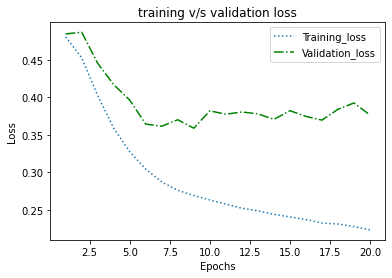

In [37]:
plt.plot(epochs,train_loss,ls=':',label='Training_loss')
plt.plot(epochs,val_loss,ls='-.',color='green',label='Validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('training v/s validation loss')
plt.legend()

In [ ]:
#So the reversed-order GRU strongly underperforms even the common-sense baseline, indicating that the in our case chronological processing is very important to 
#the success of our approach. This makes perfect sense: the underlying GRU layer will typically be better at remembering the recent past than the distant past,
#and naturally the more recent weather data points are more predictive than older data points in our problem.
#Thus the chronological version of the layer is bound to outperform the reversed-order version.

# Importantly, this is generally not true for many other problems, including natural language: intuitively, the importance of a word in
# understanding a sentence is not usually dependent on its position in the sentence.

# **Using bidirectional RNNs**

In [ ]:
from keras import backend as K
from keras.layers import Bidirectional

K.clear_session()

In [39]:
input = Input(shape=(lookback//step,float_data.shape[-1]))

output = Bidirectional(GRU(32))(input)
output = Dense(1)(output)

model = Model(inputs = input, outputs=output)
model.compile(optimizer=RMSprop(),loss='mae')
model.fit_generator(train_gen_rev,steps_per_epoch=500, epochs=40, validation_data=val_gen_rev, validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 149s 292ms/step - loss: 0.3244 - val_loss: 0.2715
Epoch 2/40
500/500 [==============================] - 146s 291ms/step - loss: 0.2782 - val_loss: 0.2701
Epoch 3/40
500/500 [==============================] - 145s 290ms/step - loss: 0.2686 - val_loss: 0.2683
Epoch 4/40
500/500 [==============================] - 147s 294ms/step - loss: 0.2623 - val_loss: 0.2651
Epoch 5/40
500/500 [==============================] - 146s 292ms/step - loss: 0.2593 - val_loss: 0.2686
Epoch 6/40
500/500 [==============================] - 145s 291ms/step - loss: 0.2523 - val_loss: 0.2709
Epoch 7/40
500/500 [==============================] - 146s 293ms/step - loss: 0.2474 - val_loss: 0.2822
Epoch 8/40
500/500 [==============================] - 146s 291ms/step - loss: 0.2420 - val_loss: 0.2811
Epoch 9/40
500/500 [==============================] - 145s 291ms/step - loss: 0.2345 - val_loss: 0.2815
Epoch 10/40
500/500 [==============================] - 145s 290m

In [40]:
dict_ = model.history.history
dict_.keys()

train_loss = dict_['loss']
val_loss = dict_['val_loss']
epochs = range(1,len(train_loss)+1)

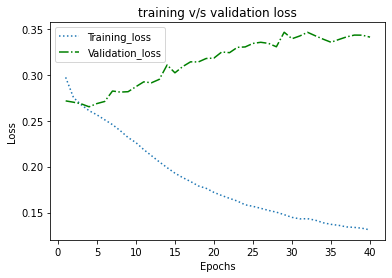

In [41]:
plt.plot(epochs,train_loss,ls=':',label='Training_loss')
plt.plot(epochs,val_loss,ls='-.',color='green',label='Validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('training v/s validation loss')
plt.legend()

In [42]:
# It performs about as well as the regular GRU layer. It's easy to understand why: all of the predictive capacity must be coming from the chronological half 
# of the network, since the anti-chronological half is known to be severely underperforming on this task (again, because the recent past matters much more 
#than the distant past in this case).

In [43]:
#Bidirectional RNNs, which look at a sequence both ways, are very useful on natural language processing problems.
# However, they will not be strong performers on sequence data where the recent past is much more informative than the beginning of the sequence.